<a href="https://colab.research.google.com/github/Sudhandar/BERT-Question-Answering/blob/master/BERT_Question_and_Answering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Question and Answering on the SQuAD Dataset- BERT

Fine tuning BERT for Question Answering and testing on the SQuAD v1.1 benchmark. The model is trained on the GPU provided by Google Colab.Fine tuning BERT results in an increase in the F1 Score compared to the pretuned BERT model.The process can be grouped into five sections,

1.   Loading the dataset
2.   Data Preprocessing
3.   Fine-Tuning BERT
4.   Performance on the test set
5.   Results

# 1.Loading the Dataset


This notebook is already configured to use a GPU, incase if you run into an issue, please do the following,

`Edit 🡒 Notebook Settings 🡒 Hardware accelerator 🡒 (GPU)`

Instructing PyTorch to use the GPU.

In [2]:
import torch

if torch.cuda.is_available():    
    device = torch.device("cuda")
    print('There are %d GPU(s) available.' % torch.cuda.device_count())
    print('Current GPU:', torch.cuda.get_device_name(0))
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
Current GPU: Tesla T4


In [3]:
torch.cuda.empty_cache()

**Installing transformers**


I have used the [transformers](https://github.com/huggingface/transformers) package from huggingface which gives a pytorch interface for working with BERT.The library  includes pre-built modifications suited to question and answering task, known as `BertForQuestionAnswering`.


In [ ]:
!pip install transformers

**Downloading Dataset**

`wget` package is used to download the dataset to the Colab instance's file system. 

In [ ]:
!pip install wget

The dataset is hosted on GitHub in this repo: https://rajpurkar.github.io/SQuAD-explorer/

In [6]:
import wget
import os

print('Downloading dataset...')
local_dir = './squad_dataset/'

# The filenames and URLs for the dataset files.
files = [('train-v1.1.json', 'https://rajpurkar.github.io/SQuAD-explorer/dataset/train-v1.1.json'), 
         ('dev-v1.1.json', 'https://rajpurkar.github.io/SQuAD-explorer/dataset/dev-v1.1.json'),
         ('evaluate-v1.1.py', 'https://github.com/allenai/bi-att-flow/blob/master/squad/evaluate-v1.1.py')]

if not os.path.exists(local_dir):
    os.mkdir(local_dir)

for (filename, url) in files:
    file_path = local_dir + filename
    if not os.path.exists(file_path):
        print('  ' + file_path)
        wget.download(url, local_dir + filename)
print('Done!')

  ./squad_dataset/train-v1.1.json
  ./squad_dataset/dev-v1.1.json
  ./squad_dataset/evaluate-v1.1.py
Done!


Printing file size and location in the drive.




In [7]:
data_dir = './squad_dataset/'
files = list(os.listdir(data_dir))

print('Dataset Location:')
print(data_dir)
for f in files:
    f_size = float(os.stat(data_dir + '/' + f).st_size) / 2**20
    print("     {:25s}    {:>6.2f} MB".format(f, f_size))

Dataset Location:
./squad_dataset/
     dev-v1.1.json                  4.63 MB
     evaluate-v1.1.py               0.13 MB
     train-v1.1.json               28.89 MB


**Parsing the Dataset**

The SQuAD dataset is stored in 'json' format. There 87,599 training samples in the dataset.

In [ ]:
import json

with open(os.path.join('./squad_dataset/train-v1.1.json'), "r", encoding="utf-8") as reader:
    input_data = json.load(reader)["data"]

examples = []
for entry in input_data:
    title = entry["title"]
    print('  ', title)
    for paragraph in entry["paragraphs"]:
        context_text = paragraph["context"]
        for qa in paragraph["qas"]:
            ex = {}
            ex['qas_id'] = qa["id"]
            ex['question_text'] = qa["question"]
            answer = qa["answers"][0]
            ex['answer_text'] = answer["text"]
            ex['start_position_character'] = answer["answer_start"]                
            ex['title'] = title
            ex['context_text'] = context_text
            examples.append(ex)

In [9]:
print('There are {:,} training examples.'.format(len(examples)))

There are 87,599 training examples.


**Inspecting Examples:**

Each example has a **question**, and a **context**, which is the reference text in which the answer can be found. 


Here are some of the field descriptions from the code:
* **qas_id**: The example's unique identifier
* **title**: Article title
* **question_text**: The question string
* **context_text**: The context string
* **answer_text**: The answer string


In [10]:
import textwrap

wrapper = textwrap.TextWrapper(width=80) 
ex = examples[260]
print('Title:', ex['title'])
print('ID:', ex['qas_id'])

print('\n======== Question =========')
print(ex['question_text'])

print('\n======== Context =========')
print(wrapper.fill(ex['context_text']))

print('\n======== Answer =========')
print(ex['answer_text'])


Title: University_of_Notre_Dame
ID: 5733ccbe4776f41900661271

======== Question =========
In what film did a parody of the "Win one for the Gipper" speech appear?

======== Context =========
In the film Knute Rockne, All American, Knute Rockne (played by Pat O'Brien)
delivers the famous "Win one for the Gipper" speech, at which point the
background music swells with the "Notre Dame Victory March". George Gipp was
played by Ronald Reagan, whose nickname "The Gipper" was derived from this role.
This scene was parodied in the movie Airplane! with the same background music,
only this time honoring George Zipp, one of Ted Striker's former comrades. The
song also was prominent in the movie Rudy, with Sean Astin as Daniel "Rudy"
Ruettiger, who harbored dreams of playing football at the University of Notre
Dame despite significant obstacles.

======== Answer =========
Airplane!


**Helper Functions:**

Few helper functions used in the Notebook. They are:

* **format_time** - Converts floating point seconds into hh:mm:ss
* **good_update_interval** - For printing updates, this will choose an interval.
* **check_gpu_mem** - Reports how much of the GPU's memory we're using.

Helper function for formatting elapsed times.

In [11]:
import time
import datetime

def format_time(elapsed):
    '''
    Takes a time in seconds and returns a string hh:mm:ss
    '''
    elapsed_rounded = int(round((elapsed)))
    return str(datetime.timedelta(seconds=elapsed_rounded))


Helper function to automatically pick a reasonable interval for printing out a progress update during training.

In [12]:
def good_update_interval(total_iters, num_desired_updates):
    '''
    Progress update interval based on the magnitude of the total iterations.
    Parameters:
      `total_iters` - The number of iterations in the for-loop.
      `num_desired_updates` - How many times we want to see an update over the 
                              course of the for-loop.
    '''
    exact_interval = total_iters / num_desired_updates
    order_of_mag = len(str(total_iters)) - 1
    round_mag = order_of_mag - 1
    update_interval = int(round(exact_interval, -round_mag))
    if update_interval == 0:
        update_interval = 1
    return update_interval

Helper function to report current GPU memory usage.

In [13]:
import pandas as pd
import csv

def check_gpu_mem():
    '''
    Uses Nvidia's SMI tool to check the current GPU memory usage.
    '''
    buf = os.popen('nvidia-smi --query-gpu=memory.total,memory.used --format=csv')
    reader = csv.reader(buf, delimiter=',')
    df = pd.DataFrame(reader)
    new_header = df.iloc[0]
    df = df[1:]
    df.columns = new_header
    return df

# 2.Data Preprocessing




 Analyzing the distribution of sequence lengths to finalize the truncation strategy.

In [14]:
from transformers import BertTokenizer
tokenizer = BertTokenizer.from_pretrained(
    'bert-base-cased',
    do_lower_case=False
)


The samples have been tokenized and encoded using the following method: 

```python
tokenizer.encode(ex['question_text'], 
                 ex['context_text'],
                 add_special_tokens = True)
```

Here are minimum, maximum, and median sequence lengths.

```
   Min length: 36 tokens
   Max length: 882 tokens
Median length: 163 tokens
```

And here is a distribution plot of the sequence lengths. 
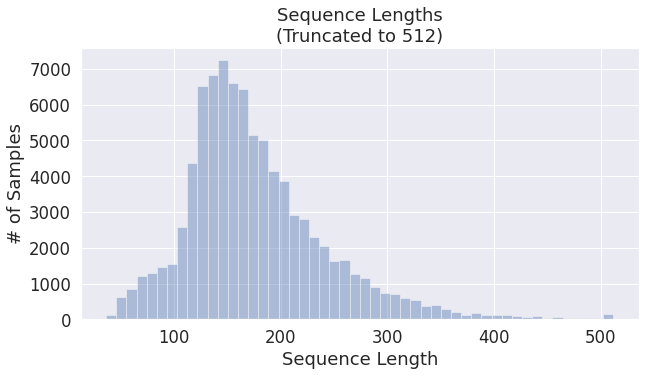

```
How many comments will be truncated depending on the max_len?

max_len = 128  -->   69,082 of  87,599  (78.9%)  will be truncated 
max_len = 256  -->    9,812 of  87,599  (11.2%)  will be truncated 
max_len = 300  -->    4,568 of  87,599  ( 5.2%)  will be truncated 
max_len = 384  -->    1,087 of  87,599  ( 1.2%)  will be truncated 
max_len = 512  -->      135 of  87,599  ( 0.2%)  will be truncated 
```




**Distributing Sequence Length:**

**Choosing max_len**

Factors that impact the maximum sequence length `max_len`:
1. **Training Time** - Training time is quadratic with `max_len`. `max_len = 512` will take 4x  longer to train than `max_len = 256`, and 16x longer than `max_len = 128`!
2. **Accuracy** - Truncating the samples to a shorter length will the hurt accuracy, due to the loss of information.
3. **GPU Memory** - For 12GB of RAM provided by Google Colab, the maximum length which can be used (without running of memory) is about `max_len = 400`.

The maximum sequence length has chosen to be `384` to match the huggingface implementation. Sequences longer than this will be truncated, and sequences shorter than this will be padded.


In [15]:
max_len = 384

**Tokenizing the training set**

In [16]:
import torch

t0 = time.time()

all_input_ids = []
attention_masks = []
segment_ids = [] 
start_positions = []
end_positions = []

num_dropped = 0

update_interval = good_update_interval(
            total_iters = len(examples), 
            num_desired_updates = 15
        )

print('Tokenizing {:,} examples...'.format(len(examples)))

for (ex_num, ex) in enumerate(examples):
    if (ex_num % update_interval) == 0 and not (ex_num == 0):
        elapsed = format_time(time.time() - t0)
        ex_per_sec = (time.time() - t0) / ex_num
        remaining_sec = ex_per_sec * (len(examples) - ex_num)
        remaining = format_time(remaining_sec)
        print('  Example {:>7,}  of  {:>7,}.    Elapsed: {:}. Remaining: {:}'.format(ex_num, len(examples), elapsed, remaining))
    answer_tokens = tokenizer.tokenize(ex['answer_text'])
    sentinel_str = ' '.join(['[MASK]']*len(answer_tokens))
    start_char_i = ex['start_position_character']
    end_char_i = start_char_i + len(ex['answer_text'])
    context_w_sentinel = ex['context_text'][:start_char_i] + \
                         sentinel_str + \
                         ex['context_text'][end_char_i:]
    encoded_dict = tokenizer.encode_plus(
        ex['question_text'], 
        context_w_sentinel,
        add_special_tokens = True,
        max_length = max_len,
        pad_to_max_length = True,
        truncation = True,
        return_attention_mask = True,
        return_tensors = 'pt',
    )
    input_ids = encoded_dict['input_ids']
    is_mask_token = (input_ids[0] == tokenizer.mask_token_id)
    mask_token_indices = is_mask_token.nonzero(as_tuple=False)[:, 0]
    if not len(mask_token_indices) == len(answer_tokens):
        num_dropped += 1
        continue
    start_index = mask_token_indices[0]
    end_index = mask_token_indices[-1]
    answer_token_ids = tokenizer.encode(answer_tokens, 
                                        add_special_tokens=False, 
                                        return_tensors='pt')
    input_ids[0, start_index : end_index + 1] = answer_token_ids
    all_input_ids.append(input_ids)
    attention_masks.append(encoded_dict['attention_mask'])    
    segment_ids.append(encoded_dict['token_type_ids'])
    start_positions.append(start_index)
    end_positions.append(end_index)

all_input_ids = torch.cat(all_input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
segment_ids = torch.cat(segment_ids, dim=0)
start_positions = torch.tensor(start_positions)
end_positions = torch.tensor(end_positions)
print('DONE.  Tokenization took {:}'.format(format_time(time.time() - t0)))

Tokenizing 87,599 examples...


/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:2022: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


  Example   6,000  of   87,599.    Elapsed: 0:00:16. Remaining: 0:03:32
  Example  12,000  of   87,599.    Elapsed: 0:00:29. Remaining: 0:03:04
  Example  18,000  of   87,599.    Elapsed: 0:00:42. Remaining: 0:02:41
  Example  24,000  of   87,599.    Elapsed: 0:00:55. Remaining: 0:02:26
  Example  30,000  of   87,599.    Elapsed: 0:01:11. Remaining: 0:02:16
  Example  36,000  of   87,599.    Elapsed: 0:01:28. Remaining: 0:02:06
  Example  42,000  of   87,599.    Elapsed: 0:01:45. Remaining: 0:01:54
  Example  48,000  of   87,599.    Elapsed: 0:02:02. Remaining: 0:01:40
  Example  54,000  of   87,599.    Elapsed: 0:02:18. Remaining: 0:01:26
  Example  60,000  of   87,599.    Elapsed: 0:02:34. Remaining: 0:01:11
  Example  66,000  of   87,599.    Elapsed: 0:02:50. Remaining: 0:00:56
  Example  72,000  of   87,599.    Elapsed: 0:03:07. Remaining: 0:00:40
  Example  78,000  of   87,599.    Elapsed: 0:03:23. Remaining: 0:00:25
  Example  84,000  of   87,599.    Elapsed: 0:03:40. Remaining: 

# 3.Fine-Tuning BERT

**Loading Initial Weights**

The `BertForQuestionAnswering` class from the `transformers` library can be used for this project.

In [ ]:
from transformers import BertForQuestionAnswering, AdamW, BertConfig

model = BertForQuestionAnswering.from_pretrained(
    "bert-base-cased",
    output_attentions = False,
    output_hidden_states = False,
)
desc = model.cuda()

In [18]:
check_gpu_mem()

,memory.total [MiB],memory.used [MiB]
1,15079 MiB,1509 MiB


**Sampling and Validation Set**


In [19]:
from torch.utils.data import TensorDataset
import numpy as np
subsample = True

if subsample:
    all_indices = np.random.permutation(all_input_ids.shape[0])
    indices = all_indices[0:87000]
    dataset = TensorDataset(all_input_ids[indices, :], 
                            attention_masks[indices, :], 
                            segment_ids[indices, :], 
                            start_positions[indices], 
                            end_positions[indices])
else:
    dataset = TensorDataset(all_input_ids, 
                            attention_masks, 
                            segment_ids, 
                            start_positions, 
                            end_positions)
print('Dataset size: {:} samples'.format(len(dataset)))

Dataset size: 87000 samples


This dataset already has a train / test split, but I'm dividing this training set to use 98% for training and 2% for validation.




In [20]:
from torch.utils.data import random_split

train_size = int(0.98 * len(dataset))
val_size = len(dataset) - train_size

train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

print('{:>5,} training samples'.format(train_size))
print('{:>5,} validation samples'.format(val_size))

85,260 training samples
1,740 validation samples


**Batch Size and DataLoaders**

BERT authors recommend batch sizes of 16 or 32. Due to our GPU restrictions, I have selected the batch size of 16.

In [21]:
from torch.utils.data import DataLoader, RandomSampler, SubsetRandomSampler, SequentialSampler
import numpy.random
import numpy as np

batch_size = 12 
train_dataloader = DataLoader(
            train_dataset,
            sampler = RandomSampler(train_dataset),
            batch_size = batch_size
        )
validation_dataloader = DataLoader(
            val_dataset,
            sampler = SequentialSampler(val_dataset),
            batch_size = batch_size
        )
print('{:,} training batches & {:,} validation batches'.format(len(train_dataloader), len(validation_dataloader)))

7,105 training batches & 145 validation batches


**Optimizer:**



For the purposes of fine-tuning, the authors recommend choosing from the following values:
- Batch size: 16, 32 
- Learning rate (Adam): 5e-5, 3e-5, 2e-5
- Number of epochs: 2, 3, 4

In [22]:
optimizer = AdamW(model.parameters(),
                  lr = 3e-5,
                  eps = 1e-8
                )

**Epochs and Learning Rate Scheduler:**

In [23]:
from transformers import get_linear_schedule_with_warmup

epochs = 2
total_steps = len(train_dataloader) * epochs
scheduler = get_linear_schedule_with_warmup(optimizer, 
                                            num_warmup_steps = 0, # Default value in run_glue.py
                                            num_training_steps = total_steps)

In [24]:
print('Total number of steps: {}'.format(total_steps))

Total number of steps: 14210


**Training Loop**

In [25]:
import random
import numpy as np

seed_val = 42

random.seed(seed_val)
np.random.seed(seed_val)
torch.manual_seed(seed_val)
torch.cuda.manual_seed_all(seed_val)

training_stats = []

for epoch_i in range(0, epochs):

    print("")
    print('======== Epoch {:} / {:} ========'.format(epoch_i + 1, epochs))
    
    print('Training {:,} batches...'.format(len(train_dataloader)))

    t0 = time.time()
    total_train_loss = 0
    model.train()
    update_interval = good_update_interval(
                total_iters = len(train_dataloader), 
                num_desired_updates = 15
            )

    num_batches = len(train_dataloader)
    for step, batch in enumerate(train_dataloader):
        if step % update_interval == 0 and not step == 0:
            elapsed = format_time(time.time() - t0)
            step_per_sec = (time.time() - t0) / step
            remaining_sec = step_per_sec * (num_batches - step)
            remaining = format_time(remaining_sec)
            print('  Batch {:>7,}  of  {:>7,}.    Elapsed: {:}. Remaining: {:}'.format(step, num_batches, elapsed, remaining))

        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_seg_ids = batch[2].to(device)
        b_start_pos = batch[3].to(device)
        b_end_pos = batch[4].to(device)

        model.zero_grad()

        outputs = model(b_input_ids, 
                        attention_mask=b_input_mask, 
                        token_type_ids = b_seg_ids,
                        start_positions=b_start_pos,
                        end_positions=b_end_pos)

        (loss, start_logits, end_logits) = outputs

        total_train_loss += loss.item()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        scheduler.step()

    avg_train_loss = total_train_loss / len(train_dataloader)            
    
    training_time = format_time(time.time() - t0)

    print("")
    print("  Average training loss: {0:.2f}".format(avg_train_loss))
    print("  Training epoch took: {:}".format(training_time))
        
    print("")
    print("Running Validation...")

    model.eval()

    total_eval_accuracy = 0
    total_eval_loss = 0

    t0_val = time.time()
    pred_start, pred_end, true_start, true_end = [], [], [], []

    for batch in validation_dataloader:
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_seg_ids = batch[2].to(device)
        b_start_pos = batch[3].to(device)
        b_end_pos = batch[4].to(device)
        with torch.no_grad():
            outputs = model(b_input_ids, 
                            token_type_ids=b_seg_ids, 
                            attention_mask=b_input_mask,
                            start_positions=b_start_pos,
                            end_positions=b_end_pos)

        (loss, start_logits, end_logits) = outputs        

        total_eval_loss += loss.item()
        start_logits = start_logits.detach().cpu().numpy()
        end_logits = end_logits.detach().cpu().numpy()
      
        b_start_pos = b_start_pos.to('cpu').numpy()
        b_end_pos = b_end_pos.to('cpu').numpy()

        answer_start = np.argmax(start_logits, axis=1)
        answer_end = np.argmax(end_logits, axis=1)

        pred_start.append(answer_start)
        pred_end.append(answer_end)
        true_start.append(b_start_pos)
        true_end.append(b_end_pos)

    pred_start = np.concatenate(pred_start, axis=0)
    pred_end = np.concatenate(pred_end, axis=0)
    true_start = np.concatenate(true_start, axis=0)
    true_end = np.concatenate(true_end, axis=0)

    num_start_correct = np.sum(pred_start == true_start)
    num_end_correct = np.sum(pred_end == true_end)

    total_correct = num_start_correct + num_end_correct
    total_indices = len(true_start) + len(true_end)

    avg_val_accuracy = float(total_correct) / float(total_indices)
    print("  Accuracy: {0:.2f}".format(avg_val_accuracy))

    avg_val_loss = total_eval_loss / len(validation_dataloader)
    
    validation_time = format_time(time.time() - t0_val)
    print("  Validation Loss: {0:.2f}".format(avg_val_loss))
    print("  Validation took: {:}".format(validation_time))

    training_stats.append(
        {
            'epoch': epoch_i + 1,
            'Training Loss': avg_train_loss,
            'Valid. Loss': avg_val_loss,
            'Valid. Accur.': avg_val_accuracy,
            'Training Time': training_time,
            'Validation Time': validation_time
        }
    )

print("")
print("Training complete!")


======== Epoch 1 / 2 ========
Training 7,105 batches...
  Batch     500  of    7,105.    Elapsed: 0:07:30. Remaining: 1:39:01
  Batch   1,000  of    7,105.    Elapsed: 0:15:02. Remaining: 1:31:49
  Batch   1,500  of    7,105.    Elapsed: 0:22:36. Remaining: 1:24:27
  Batch   2,000  of    7,105.    Elapsed: 0:30:09. Remaining: 1:16:58
  Batch   2,500  of    7,105.    Elapsed: 0:37:42. Remaining: 1:09:27
  Batch   3,000  of    7,105.    Elapsed: 0:45:16. Remaining: 1:01:57
  Batch   3,500  of    7,105.    Elapsed: 0:52:50. Remaining: 0:54:25
  Batch   4,000  of    7,105.    Elapsed: 1:00:24. Remaining: 0:46:53
  Batch   4,500  of    7,105.    Elapsed: 1:07:57. Remaining: 0:39:20
  Batch   5,000  of    7,105.    Elapsed: 1:15:30. Remaining: 0:31:47
  Batch   5,500  of    7,105.    Elapsed: 1:23:04. Remaining: 0:24:14
  Batch   6,000  of    7,105.    Elapsed: 1:30:37. Remaining: 0:16:41
  Batch   6,500  of    7,105.    Elapsed: 1:38:10. Remaining: 0:09:08
  Batch   7,000  of    7,105.    

**Training Results**

**Checking for Over-Fitting**


In [35]:
import pandas as pd

df_stats = pd.DataFrame(data=training_stats)
df_stats = df_stats.set_index('epoch')
pd.set_option('precision', 2)
df_stats

,Training Loss,Valid. Loss,Valid. Accur.,Training Time,Validation Time
epoch,,,,,
1,1.23,0.92,0.72,1:47:19,0:00:45
2,0.70,0.93,0.73,1:47:18,0:00:45


The validation loss has remained constant in the two epochs (very minimal increase is observed). Training the model any further will result in overfitting.

# 4.Performance On Test Set

Loading the holdout dataset and testing the fine-tuned BERT's performance.

**Parsing Test Set**

There are **3 answers** provided for every question. These are three human-provided answers, and they don't always agree. For example, for the question:

```
Where did Super Bowl 50 take place?
```

The annotators produced:
```
   {'answer_start': 403, 'text': 'Santa Clara, California'}
   {'answer_start': 355, 'text': "Levi's Stadium"}
   {'answer_start': 355, 'text': "Levi's Stadium in the San Francisco Bay Area at Santa Clara, California."}
```

Since all three seem acceptable, BERT's prediction to all three correct answers are compared, and  the highest F1 score that BERT gets among the three is considered.

In [38]:
import json

with open(os.path.join('./squad_dataset/dev-v1.1.json'), "r", encoding="utf-8") as reader:
    input_data = json.load(reader)["data"]

print_count = 0
print('Unpacking SQuAD Examples...')

print('Articles:')

examples = []
for entry in input_data:
    title = entry["title"]
    print('  ', title)
    for paragraph in entry["paragraphs"]:
        context_text = paragraph["context"]
        for qa in paragraph["qas"]:
            ex = {}
            ex['qas_id'] = qa["id"]
            ex['question_text'] = qa["question"]
            ex['answers'] = qa["answers"]
            ex['title'] = title
            ex['context_text'] = context_text
            examples.append(ex)
print('DONE!')

Unpacking SQuAD Examples...
Articles:
   Super_Bowl_50
   Warsaw
   Normans
   Nikola_Tesla
   Computational_complexity_theory
   Teacher
   Martin_Luther
   Southern_California
   Sky_(United_Kingdom)
   Victoria_(Australia)
   Huguenot
   Steam_engine
   Oxygen
   1973_oil_crisis
   Apollo_program
   European_Union_law
   Amazon_rainforest
   Ctenophora
   Fresno,_California
   Packet_switching
   Black_Death
   Geology
   Newcastle_upon_Tyne
   Victoria_and_Albert_Museum
   American_Broadcasting_Company
   Genghis_Khan
   Pharmacy
   Immune_system
   Civil_disobedience
   Construction
   Private_school
   Harvard_University
   Jacksonville,_Florida
   Economic_inequality
   Doctor_Who
   University_of_Chicago
   Yuan_dynasty
   Kenya
   Intergovernmental_Panel_on_Climate_Change
   Chloroplast
   Prime_number
   Rhine
   Scottish_Parliament
   Islamism
   Imperialism
   United_Methodist_Church
   French_and_Indian_War
   Force
DONE!


In [39]:
print('There are {:,} test examples.'.format(len(examples)))

There are 10,570 test examples.


**Locating Test Answers**

For the test samples, a 2-pass approach has been followed to tokenize the dataset. 

In the first pass,all the samples are tokenized **without any truncation or padding**, which allows us to correctly locate the answers, even if their token indices are greater than 384.

In the second pass, the samples are tokenized and encoded , with padding and truncation.


In [40]:
import time
import torch
import logging

logging.getLogger("transformers.tokenization_utils_base").setLevel(logging.ERROR)

t0 = time.time()
start_positions = []
end_positions = []
num_clipped_answers = 0
num_impossible = 0

update_interval = good_update_interval(
            total_iters = len(examples), 
            num_desired_updates = 15
        )

print('Processing {:,} examples...'.format(len(examples)))

for (ex_num, ex) in enumerate(examples):

    if (ex_num % update_interval) == 0 and not (ex_num == 0):

        elapsed = format_time(time.time() - t0)
        ex_per_sec = (time.time() - t0) / ex_num
        remaining_sec = ex_per_sec * (len(examples) - ex_num)
        remaining = format_time(remaining_sec)
        print('  Example {:>7,}  of  {:>7,}.    Elapsed: {:}. Remaining: {:}'.format(ex_num, len(examples), elapsed, remaining))
    start_options = []
    end_options = []

    encoded_stored = False
    for answer in ex['answers']:
        answer_tokens = tokenizer.tokenize(answer['text'])
        sentinel_str = ' '.join(['[MASK]']*len(answer_tokens))
        start_char_i = answer['answer_start']
        end_char_i = start_char_i + len(answer['text'])
        context_w_sentinel = ex['context_text'][:start_char_i] + \
                            sentinel_str + \
                            ex['context_text'][end_char_i:]
        input_ids = tokenizer.encode(
            ex['question_text'], 
            context_w_sentinel,
            add_special_tokens = True, 
            #max_length = max_len,
            pad_to_max_length = False,
            truncation = False,
        )
        mask_token_indices = np.where(np.array(input_ids) == tokenizer.mask_token_id)[0]
        assert(len(mask_token_indices) == len(answer_tokens))           
        start_index = mask_token_indices[0]
        end_index = mask_token_indices[-1]
        start_options.append(start_index)
        end_options.append(end_index)
    
    start_positions.append(start_options)
    end_positions.append(end_options)

print('DONE.  Tokenization took {:}'.format(format_time(time.time() - t0)))

Processing 10,570 examples...
  Example   1,000  of   10,570.    Elapsed: 0:00:06. Remaining: 0:00:55
  Example   2,000  of   10,570.    Elapsed: 0:00:11. Remaining: 0:00:47
  Example   3,000  of   10,570.    Elapsed: 0:00:17. Remaining: 0:00:42
  Example   4,000  of   10,570.    Elapsed: 0:00:25. Remaining: 0:00:41
  Example   5,000  of   10,570.    Elapsed: 0:00:34. Remaining: 0:00:38
  Example   6,000  of   10,570.    Elapsed: 0:00:41. Remaining: 0:00:31
  Example   7,000  of   10,570.    Elapsed: 0:00:49. Remaining: 0:00:25
  Example   8,000  of   10,570.    Elapsed: 0:00:56. Remaining: 0:00:18
  Example   9,000  of   10,570.    Elapsed: 0:01:02. Remaining: 0:00:11
  Example  10,000  of   10,570.    Elapsed: 0:01:10. Remaining: 0:00:04
DONE.  Tokenization took 0:01:15


Effect of truncation strategy on the  test set questions.



In [41]:
num_impossible = 0
num_clipped = 0

for (start_options, end_options) in zip(start_positions, end_positions):

    is_possible = False
    for i in range(0, len(start_options)):
        if (start_options[i] < max_len) and (end_options[i] < max_len):
            is_possible = True
        if (start_options[i] > max_len) or (end_options[i] > max_len):
            num_clipped += 1
    if not is_possible:
        num_impossible += 1

print('')

print('Samples w/ all answers clipped: {:,} of {:,} ({:.2%})'.format(num_impossible, len(examples), float(num_impossible) / float(len(examples))))

addtl_clipped = num_clipped - (num_impossible * 3)
total_answers = len(examples) * 3
print('\n    Additional clipped answers: {:,} of {:,}'.format(addtl_clipped, total_answers))


Samples w/ all answers clipped: 31 of 10,570 (0.29%)

    Additional clipped answers: 19 of 31,710


**Tokenizing and Encoding the  Test Samples**

In [42]:
import time
import torch

t0 = time.time()
all_input_ids = []
attention_masks = []
segment_ids = [] 

update_interval = good_update_interval(
            total_iters = len(examples), 
            num_desired_updates = 15
        )

print('Tokenizing {:,} examples...'.format(len(examples)))

for (ex_num, ex) in enumerate(examples):

    if (ex_num % update_interval) == 0 and not (ex_num == 0):
        elapsed = format_time(time.time() - t0)
        ex_per_sec = (time.time() - t0) / ex_num
        remaining_sec = ex_per_sec * (len(examples) - ex_num)
        remaining = format_time(remaining_sec)
        print('  Example {:>7,}  of  {:>7,}.    Elapsed: {:}. Remaining: {:}'.format(ex_num, len(examples), elapsed, remaining))

    encoded_dict = tokenizer.encode_plus(
        ex['question_text'], 
        ex['context_text'],
        add_special_tokens = True,
        max_length = max_len,
        pad_to_max_length = True,
        truncation = True,
        return_attention_mask = True,
        return_tensors = 'pt',
    )
    input_ids = encoded_dict['input_ids']
 
    all_input_ids.append(input_ids)
    attention_masks.append(encoded_dict['attention_mask'])    
    segment_ids.append(encoded_dict['token_type_ids'])
all_input_ids = torch.cat(all_input_ids, dim=0)
attention_masks = torch.cat(attention_masks, dim=0)
segment_ids = torch.cat(segment_ids, dim=0)

print('DONE.  Tokenization took {:}'.format(format_time(time.time() - t0)))

Tokenizing 10,570 examples...


/usr/local/lib/python3.6/dist-packages/transformers/tokenization_utils_base.py:2022: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  FutureWarning,


  Example   1,000  of   10,570.    Elapsed: 0:00:02. Remaining: 0:00:20
  Example   2,000  of   10,570.    Elapsed: 0:00:04. Remaining: 0:00:16
  Example   3,000  of   10,570.    Elapsed: 0:00:06. Remaining: 0:00:15
  Example   4,000  of   10,570.    Elapsed: 0:00:08. Remaining: 0:00:13
  Example   5,000  of   10,570.    Elapsed: 0:00:11. Remaining: 0:00:12
  Example   6,000  of   10,570.    Elapsed: 0:00:13. Remaining: 0:00:10
  Example   7,000  of   10,570.    Elapsed: 0:00:16. Remaining: 0:00:08
  Example   8,000  of   10,570.    Elapsed: 0:00:18. Remaining: 0:00:06
  Example   9,000  of   10,570.    Elapsed: 0:00:20. Remaining: 0:00:04
  Example  10,000  of   10,570.    Elapsed: 0:00:23. Remaining: 0:00:01
DONE.  Tokenization took 0:00:24




**Evaluate On Test Set**

In [43]:
import time
import numpy as np

model.eval()

t0 = time.time()
pred_start = []
pred_end = []
num_test_samples = all_input_ids.shape[0]
batch_size = 16

num_batches = int(np.ceil(num_test_samples / batch_size))

print('Evaluating on {:,} test batches...'.format(num_batches))

batch_num = 0
for start_i in range(0, num_test_samples, batch_size):
    if ((batch_num % 50) == 0) and not (batch_num == 0):
      elapsed = format_time(time.time() - t0)
      batches_per_sec = (time.time() - t0) / batch_num
      remaining_sec = batches_per_sec * (num_batches - batch_num)
      remaining = format_time(remaining_sec)
      print('  Batch {:>7,}  of  {:>7,}.    Elapsed: {:}. Remaining: {:}'.format(batch_num, num_batches, elapsed, remaining))

    end_i = min(start_i + batch_size, num_test_samples)
    b_input_ids = all_input_ids[start_i:end_i, :]
    b_attn_masks = attention_masks[start_i:end_i, :]
    b_seg_ids = segment_ids[start_i:end_i, :]   

    b_input_ids = b_input_ids.to(device)
    b_attn_masks = b_attn_masks.to(device)
    b_seg_ids = b_seg_ids.to(device)

    with torch.no_grad():
        (start_logits, end_logits) = model(b_input_ids, 
                                           attention_mask=b_attn_masks,
                                           token_type_ids=b_seg_ids)
    start_logits = start_logits.detach().cpu().numpy()
    end_logits = end_logits.detach().cpu().numpy()

    answer_start = np.argmax(start_logits, axis=1)
    answer_end = np.argmax(end_logits, axis=1)

    pred_start.append(answer_start)
    pred_end.append(answer_end)

    batch_num += 1

pred_start = np.concatenate(pred_start, axis=0)
pred_end = np.concatenate(pred_end, axis=0)

print('    DONE.')

print('\nEvaluation took {:.0f} seconds.'.format(time.time() - t0))

Evaluating on 661 test batches...
  Batch      50  of      661.    Elapsed: 0:00:21. Remaining: 0:04:20
  Batch     100  of      661.    Elapsed: 0:00:43. Remaining: 0:04:00
  Batch     150  of      661.    Elapsed: 0:01:03. Remaining: 0:03:35
  Batch     200  of      661.    Elapsed: 0:01:23. Remaining: 0:03:12
  Batch     250  of      661.    Elapsed: 0:01:44. Remaining: 0:02:51
  Batch     300  of      661.    Elapsed: 0:02:05. Remaining: 0:02:30
  Batch     350  of      661.    Elapsed: 0:02:25. Remaining: 0:02:09
  Batch     400  of      661.    Elapsed: 0:02:46. Remaining: 0:01:48
  Batch     450  of      661.    Elapsed: 0:03:06. Remaining: 0:01:27
  Batch     500  of      661.    Elapsed: 0:03:27. Remaining: 0:01:07
  Batch     550  of      661.    Elapsed: 0:03:48. Remaining: 0:00:46
  Batch     600  of      661.    Elapsed: 0:04:08. Remaining: 0:00:25
  Batch     650  of      661.    Elapsed: 0:04:29. Remaining: 0:00:05
    DONE.

Evaluation took 273 seconds.


#5.Results

There are two standard approaches to scoring results on the SQuAD benchmark:

1. Exact Match
2. F1 Score

**Exact Match**

For this metric, the number of predicted start indices that are equal to the correct ones are added up. It is done for  the end indices as well, such that there are actually two "points" for every sample.

To handle the 3 possible answers, we score our predictions against each of the answers separately, and select the  answer which best matches our prediction. So for each test sample, the highest possible score is 2. 

In [44]:

total_correct = 0

for i in range(0, len(pred_start)):

    match_options = []
    for j in range (0, len(start_positions[i])):
        matches = 0
        if pred_start[i] == start_positions[i][j]:
            matches += 1
        if pred_end[i] == end_positions[i][j]:
            matches += 1

        match_options.append(matches)

    total_correct += (max(match_options))
total_indices = len(pred_start) + len(pred_end)

print('Correctly predicted indeces: {:,} of {:,} ({:.2%})'.format(
    total_correct,
    total_indices,
    float(total_correct) / float(total_indices)
))


Correctly predicted indeces: 17,751 of 21,140 (83.97%)


**F1 Score**

The F1 score gives our model credit for predicting a span which partially intersects the correct one.

*Formula :* 
```python
    precision = 1.0 * num_same / len(pred_toks)
    recall = 1.0 * num_same / len(gold_toks)
    f1 = (2 * precision * recall) / (precision + recall)
```
To handle the 3 possible answers, F1 score for each sample is calculated separately and the one with the highest score is considered. 

The final F1 score is determined by taking the average over all the test samples.


In [45]:
f1s = []
for i in range(0, len(pred_start)):
    pred_span = set(range(pred_start[i], pred_end[i] + 1))
    f1_options = []
    for j in range (0, len(start_positions[i])):
        true_span = set(range(start_positions[i][j], end_positions[i][j] + 1))    
        num_same = len(pred_span.intersection(true_span))
        if num_same == 0:
            f1_options.append(0)
            continue
        precision = float(num_same) / float(len(pred_span))
        recall = float(num_same) / float(len(true_span))
        f1 = (2 * precision * recall) / (precision + recall)
        f1_options.append(f1)
    f1s.append(max(f1_options))

print('Average F1 Score: {:.3f}'.format(np.mean(f1s)))

Average F1 Score: 0.863


**Final Score of our fine tuned BERT base model:**

```
Correctly predicted indices: 17,751 of 21,140 (83.97%)

Average F1 Score: 0.863
```

